In [23]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns

# Imports

In [24]:
df = pd.read_csv('../clustering_data.csv')
df = df.drop(columns=['Area Code'])
df = df.replace([np.inf, -np.inf], np.nan)
targets = ['mean_happiness_3clusters', 'mean_happiness_binary', 'mean_happiness']

df.shape

(3429, 427)

In [25]:
code_cols = [col for col in df if col.startswith('Code')]
df.drop(columns=code_cols, inplace=True)

region_cols = [col for col in df if col.startswith('region')]
df.drop(columns=region_cols, inplace=True)

df = df.astype(float)

columns = df.columns[~df.columns.isin(targets)]

df.columns

Index(['Year', 'mean_happiness', 'suicide_rates', 'crimes', 'population',
       'population_density', 'unemployment', 'mean_income_support',
       'n_is_claimants', 'house_sales', 'bankruptcy', 'processing',
       'productivity', 'road_casualties', 'ofsted', 'infant_mortality',
       'childhood_tooth_decay', 'gp_access', 'dental_access',
       'mean_happiness_3clusters', 'mean_happiness_binary', 'Core City',
       'Other City', 'Large Town', 'Medium Town', 'Small Town',
       'Village or smaller', 'gardens_perc', 'income_support_rate',
       'house_sales_pp', 'bankruptcy_pp', 'no_rainy_days', 'inflation',
       'previous_period_happiness_change'],
      dtype='object')

# Normalise

C:\Users\gv9\Anaconda3\envs\uniwork\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gv9\Anaconda3\envs\uniwork\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\gv9\Anaconda3\envs\uniwork\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

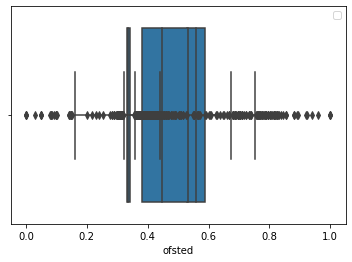

In [31]:
for column in df[['suicide_rates', 
       'population_density',  'ofsted']].columns:          
    sns.boxplot(df[column])
    
plt.legend()
plt.show()

In [27]:
df = df.copy()
min_max_scaler = MinMaxScaler()
df[columns] = min_max_scaler.fit_transform(df[columns])

In [29]:
for column in df[['ofsted', 'population_density', 'suicide_rates']].columns:          
    sns.scatter(df[column], label=column)
    
plt.legend()
plt.show()

AttributeError: module 'seaborn' has no attribute 'scatter'

# Export with Nans

In [15]:
print(df.shape)

y = df['mean_happiness_binary']
X = df[columns]

#Splitting into train test validate, 80 : 10 : 10
X_train, X_remaining, y_train, y_remaining = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

print(len(X_train))
print(len(y_train))

X_train.to_csv('../processed_data/with_nans/x_train.csv', index=False)
y_train.to_csv('../processed_data/with_nans/y_train.csv', index=False)

X_test.to_csv('../processed_data/with_nans/X_test.csv', index=False)
y_test.to_csv('../processed_data/with_nans/y_test.csv', index=False)

X_valid.to_csv('../processed_data/with_nans/X_valid.csv', index=False)
y_valid.to_csv('../processed_data/with_nans/y_valid.csv', index=False)

(3429, 34)
2743
2743


# Imputation

In [23]:
for method in ['most_frequent', 'mean', 'median']:
    
    #imputing training data
    imputed_train = SimpleImputer(strategy=method).fit_transform(X_train)
    x_train_imputed = pd.DataFrame(imputed_train, columns=X_train.columns)
    
    #imputing testing data
    X_full = X_test.append(X_train)
    imputed_full = SimpleImputer(strategy=method).fit_transform(X_full)
    x_full_imputed = pd.DataFrame(imputed_full, columns=X_test.columns)
    x_test_imputed = x_full_imputed[:len(X_test)]
    
    x_test_imputed.to_excel(f'../processed_data/imputed/{method}/x_test.xlsx', index=False)
    x_train_imputed.to_excel(f'../processed_data/imputed/{method}/x_train.xlsx', index=False)
    pd.Series(y_train).to_excel(f'../processed_data/imputed/{method}/y_train.xlsx', index=False)
    pd.Series(y_test).to_excel(f'../processed_data/imputed/{method}/y_test.xlsx', index=False)

# KNN

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier

imputer = KNNImputer(n_neighbors=50, weights='distance')

# imputing training
imputer.fit(X_train)
X_train_knn = imputer.transform(X_train)
X_train_knn_df = pd.DataFrame(X_train_knn, columns=X_train.columns)

# imputing test data
X_full = X_test.append(X_train)
X_full_imputed = imputer.fit_transform(X_full)
X_full_knn_df = pd.DataFrame(X_full_imputed, columns=X_full.columns)
X_test_knn_df = X_full_knn_df[:len(X_test)]

method='knn'

X_test_knn_df.to_excel(f'../processed_data/imputed/{method}/x_test.xlsx', index=False)
X_train_knn_df.to_excel(f'../processed_data/imputed/{method}/x_train.xlsx', index=False)
pd.Series(y_train).to_excel(f'../processed_data/imputed/{method}/y_train.xlsx', index=False)
pd.Series(y_test).to_excel(f'../processed_data/imputed/{method}/y_test.xlsx', index=False)

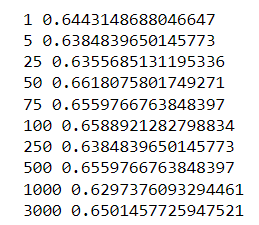

# Dropped Nans

In [24]:
#remove cols with more than 800 nans
print('NaNs: ')
print(df.isna().sum().sort_values(ascending=False)[:15])

columns_1 = df.columns

threshold = len(df) - 801
print('\nThreshold: ', threshold)
print('Original shape:', df.shape)
df = df.dropna(axis=1, thresh=threshold)
print('Shape after removing columns with less than', threshold, 'values:', df.shape)

columns_dropped = set(columns_1) - set(df.columns) 
print('\ncolumns_dropped:\n', columns_dropped)

columns = df.columns[~df.columns.isin(targets)]

df_no_nans = df.dropna(axis=0)
print(df_no_nans.shape)
y = df_no_nans['mean_happiness_binary']
X = df_no_nans[columns]

NaNs: 
dental_access                       3116
gp_access                           2671
ofsted                              2412
road_casualties                     1909
childhood_tooth_decay               1520
processing                           989
infant_mortality                     974
crimes                               800
bankruptcy_pp                        489
house_sales_pp                       489
suicide_rates                        486
house_sales                          486
productivity                         469
bankruptcy                           423
previous_period_happiness_change     405
dtype: int64

Threshold:  2628
Original shape: (3429, 34)
Shape after removing columns with less than 2628 values: (3429, 27)

columns_dropped:
 {'road_casualties', 'processing', 'childhood_tooth_decay', 'gp_access', 'ofsted', 'dental_access', 'infant_mortality'}
(1972, 27)


In [25]:
#Splitting into train test validate, 80 : 10 : 10
X_train, X_remaining, y_train, y_remaining = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

X_train.to_csv('../processed_data/nans_removed/x_train.csv', index=False)
y_train.to_csv('../processed_data/nans_removed/y_train.csv', index=False)

X_test.to_csv('../processed_data/nans_removed/X_test.csv', index=False)
y_test.to_csv('../processed_data/nans_removed/y_test.csv', index=False)

X_valid.to_csv('../processed_data/nans_removed/X_valid.csv', index=False)
y_valid.to_csv('../processed_data/nans_removed/y_valid.csv', index=False)

## 3 Clusters

In [26]:
y = df_no_nans['mean_happiness_3clusters']
X = df_no_nans[columns]

#Splitting into train test validate, 80 : 10 : 10
X_train, X_remaining, y_train, y_remaining = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

X_train.to_csv('../processed_data/3_clusters/x_train.csv', index=False)
y_train.to_csv('../processed_data/3_clusters/y_train.csv', index=False)

X_test.to_csv('../processed_data/3_clusters/X_test.csv', index=False)
y_test.to_csv('../processed_data/3_clusters/y_test.csv', index=False)

X_valid.to_csv('../processed_data/3_clusters/X_valid.csv', index=False)
y_valid.to_csv('../processed_data/3_clusters/y_valid.csv', index=False)

In [27]:
X_train

,Year,suicide_rates,crimes,population,population_density,unemployment,mean_income_support,n_is_claimants,house_sales,bankruptcy,...,Medium Town,Small Town,Village or smaller,gardens_perc,income_support_rate,house_sales_pp,bankruptcy_pp,no_rainy_days,inflation,previous_period_happiness_change
1151,0.375,0.463768,0.736753,0.343446,0.358331,0.562465,0.462864,0.943170,0.465032,0.536585,...,0.000000,0.007485,0.045605,0.884658,0.449197,0.789866,0.535352,0.358763,0.070547,0.528634
1473,0.375,0.521739,0.670260,0.356006,0.355400,0.616232,0.460184,0.961234,0.488486,0.678049,...,0.009011,0.000000,0.024697,0.868981,0.449520,0.790058,0.537308,0.358763,0.070547,0.577093
2594,0.750,0.565217,0.668681,0.248449,0.333996,0.596714,0.462098,0.979805,0.366098,0.800000,...,0.000000,0.269974,0.759489,0.910414,0.449066,0.788584,0.539774,0.200000,0.359422,0.704846
1600,0.500,0.543478,0.670941,0.249897,0.335437,0.630310,0.530245,0.987721,0.439659,0.770732,...,0.234952,0.600431,0.255831,0.967525,0.449586,0.793325,0.538211,0.247423,0.679061,0.607930
1542,0.500,0.637681,0.674707,0.235890,0.332989,0.683600,0.541348,0.982444,0.407463,0.741463,...,0.000000,0.474711,0.577097,0.945129,0.448705,0.793695,0.535322,0.247423,0.679061,0.356828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,0.500,0.528986,0.729507,0.296723,0.342249,0.386324,0.502297,0.973716,0.467804,0.868293,...,0.000000,0.053142,0.072270,0.922732,0.449478,0.790968,0.540385,0.247423,0.679061,0.519824
2099,0.625,0.565217,0.667820,0.269072,0.376811,0.512004,0.516080,0.953724,0.064819,0.814634,...,0.000000,0.000000,0.000000,0.760358,0.448453,0.776245,0.539711,0.674227,1.000000,0.563877
1538,0.500,0.456522,0.715696,0.299876,0.334286,0.686631,0.538285,0.961335,0.562260,0.673171,...,0.368068,0.284626,0.224176,0.935050,0.449207,0.793233,0.536418,0.247423,0.679061,0.462555
2331,0.750,0.608696,0.743867,0.259355,0.336052,0.627834,0.462098,0.990055,0.397015,0.858537,...,0.260745,0.486136,0.294329,0.950728,0.449785,0.790007,0.541743,0.200000,0.359422,0.497797


# Original non converging Imputation

In [28]:
'''imputer = IterativeImputer()
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)

y = df_imputed['mean_happiness_binary']
X = df_imputed[columns]

#Splitting into train test validate, 80 : 10 : 10
X_train, X_remaining, y_train, y_remaining = train_test_split(X,y, train_size=0.8, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

X_train.to_csv('../processed_data/imputed/x_train.csv', index=False)
y_train.to_csv('../processed_data/imputed/y_train.csv', index=False)

X_test.to_csv('../processed_data/imputed/X_test.csv', index=False)
y_test.to_csv('../processed_data/imputed/y_test.csv', index=False)

X_valid.to_csv('../processed_data/imputed/X_valid.csv', index=False)
y_valid.to_csv('../processed_data/imputed/y_valid.csv', index=False)'''

"imputer = IterativeImputer()\nimputed = imputer.fit_transform(df)\ndf_imputed = pd.DataFrame(imputed, columns=df.columns)\n\ny = df_imputed['mean_happiness_binary']\nX = df_imputed[columns]\n\n#Splitting into train test validate, 80 : 10 : 10\nX_train, X_remaining, y_train, y_remaining = train_test_split(X,y, train_size=0.8, random_state=42)\nX_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)\n\nX_train.to_csv('../processed_data/imputed/x_train.csv', index=False)\ny_train.to_csv('../processed_data/imputed/y_train.csv', index=False)\n\nX_test.to_csv('../processed_data/imputed/X_test.csv', index=False)\ny_test.to_csv('../processed_data/imputed/y_test.csv', index=False)\n\nX_valid.to_csv('../processed_data/imputed/X_valid.csv', index=False)\ny_valid.to_csv('../processed_data/imputed/y_valid.csv', index=False)"

NameError: name 'X_train' is not defined